In [9]:
"""
================================================================================
QUANTUM COMPUTING PROJECT: Historical Data Analysis (using PennyLane)
================================================================================

This notebook demonstrates the power of quantum computing through:
1. Classical ML (KNN/SVM): Predicting gladiator survival - explainable and beginner-friendly
2. Data Integration: Connecting gladiator data with historical Wikipedia periods
3. Quantum Optimization: Finding optimal groupings in historical Wikipedia data using "QAOA"

Authors: Greg and Victor
================================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# PennyLane imports for quantum computing
import pennylane as qml
from pennylane import numpy as pnp

# Set random seeds for reproducibility
np.random.seed(777)
pnp.random.seed(777)

print("=" * 80)
print("QUANTUM COMPUTING PROJECT: Historical Data Analysis")
print("=" * 80)
print("\nLibraries imported successfully!")
print(f"PennyLane version: {qml.__version__}")

QUANTUM COMPUTING PROJECT: Historical Data Analysis

Libraries imported successfully!
PennyLane version: 0.42.3


# Part 1: Data Loading and Exploration

Let's start by loading and exploring our historical datasets.


In [10]:
# Load the gladiator dataset
# This dataset contains information about ancient Roman gladiators
gladiator_df = pd.read_csv("gladiator_data.csv")

print("=" * 80)
print("GLADIATOR DATASET OVERVIEW")
print("=" * 80)
print(f"Shape: {gladiator_df.shape}")
print(f"\nColumns: {list(gladiator_df.columns)}")
print(f"\nFirst few rows:")
print(gladiator_df.head())
print(f"\nSurvival rate: {gladiator_df['Survived'].mean():.2%}")
print(f"\nMissing values:\n{gladiator_df.isnull().sum().sum()}")


GLADIATOR DATASET OVERVIEW
Shape: (9976, 29)

Columns: ['Name', 'Age', 'Birth Year', 'Origin', 'Height', 'Weight', 'Category', 'Wins', 'Losses', 'Special Skills', 'Weapon of Choice', 'Patron Wealth', 'Equipment Quality', 'Public Favor', 'Injury History', 'Mental Resilience', 'Diet and Nutrition', 'Tactical Knowledge', 'Allegiance Network', 'Battle Experience', 'Psychological Profile', 'Health Status', 'Personal Motivation', 'Previous Occupation', 'Training Intensity', 'Battle Strategy', 'Social Standing', 'Crowd Appeal Techniques', 'Survived']

First few rows:
                Name  Age  Birth Year Origin  Height  Weight     Category  \
0       Aelius Verus   32          97   Gaul     195      85       Thraex   
1  Cocceius Galerius   20          32   Gaul     173      66  Hoplomachus   
2      Pedius Furius   30          66   Gaul     170      67  Hoplomachus   
3  Maximian Maecenas   28          43   Gaul     189     104  Hoplomachus   
4    Celsus Laronius   41         126   Rome    

In [11]:
# Load the Wikipedia historical dataset
wiki_df = pd.read_csv("wiki_data.csv")

print("=" * 80)
print("WIKIPEDIA HISTORICAL DATASET OVERVIEW")
print("=" * 80)
print(f"Shape: {wiki_df.shape}")
print(f"\nColumns: {list(wiki_df.columns)}")
print(f"\nFirst few entries:")
print(wiki_df[['title', 'relevans', 'popularity', 'ranking']].head(10))
print(f"\nMissing values:\n{wiki_df.isnull().sum()}")


WIKIPEDIA HISTORICAL DATASET OVERVIEW
Shape: (1077, 5)

Columns: ['title', 'text', 'relevans', 'popularity', 'ranking']

First few entries:
                    title  relevans  popularity   ranking
0          Westernization  0.815325    0.993961  0.810401
1             Anachronism  0.810980    0.998420  0.809699
2  Pre-industrial society  0.814736    0.993420  0.809376
3           Periodization  0.811482    0.995228  0.807610
4       History of Europe  0.804999    0.998863  0.804084
5     Early modern period  0.801404    0.999153  0.800725
6        Three-age system  0.801034    0.997677  0.799174
7           Human history  0.799215    0.999453  0.798777
8   Golden age (metaphor)  0.804347    0.992059  0.797959
9       Industrialisation  0.799944    0.997364  0.797835

Missing values:
title         0
text          0
relevans      0
popularity    0
ranking       0
dtype: int64


# Part 2: Classical Machine Learning - Gladiator Survival Prediction

## Overview
We'll use **K-Nearest Neighbors (KNN)** and **Support Vector Machine (SVM)** to predict whether a gladiator survived based on their characteristics. These classical ML methods are more beginner-friendly and explainable than quantum classifiers.

### Why KNN and SVM?
- **KNN**: Simple, intuitive - predicts based on similar gladiators. Easy to explain: "This gladiator survived because the 5 most similar gladiators also survived."
- **SVM**: Finds optimal decision boundaries. Can visualize which features separate survivors from non-survivors.
- **Explainability**: Both methods allow us to understand WHY predictions are made, unlike black-box models.

### Key Concepts:
- **K-Nearest Neighbors**: Classifies based on the k most similar training examples
- **Support Vector Machine**: Finds the optimal hyperplane that best separates the classes
- **Feature Importance**: Understanding which gladiator characteristics matter most for survival


In [12]:
# ============================================================================
# DATA PREPROCESSING FOR CLASSICAL ML
# ============================================================================

# Select relevant numerical and categorical features for prediction
# We'll use a mix of features that could influence survival

# Numerical features
numerical_features = ['Age', 'Height', 'Weight', 'Wins', 'Losses', 
                      'Public Favor', 'Mental Resilience', 'Battle Experience']

# Categorical features to encode
categorical_features = ['Category', 'Special Skills', 'Weapon of Choice', 
                        'Patron Wealth', 'Equipment Quality', 'Health Status']

# Create a working copy
df_work = gladiator_df.copy()

# Encode categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_work[col + '_encoded'] = le.fit_transform(df_work[col].astype(str))
    label_encoders[col] = le

# Combine features
feature_cols = numerical_features + [col + '_encoded' for col in categorical_features]
X = df_work[feature_cols].values
y = df_work['Survived'].astype(int).values  # Convert True/False to 1/0

# Normalize features (important for distance-based methods like KNN and SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Analyze feature importance
correlations = []
for i, col in enumerate(feature_cols):
    corr = np.abs(np.corrcoef(X[:, i], y)[0, 1])
    correlations.append((i, corr, col))

correlations.sort(key=lambda x: x[1], reverse=True)

print("Feature correlations with survival:")
print("-" * 60)
for i, (idx, corr, name) in enumerate(correlations):
    print(f"{i+1:2d}. {name:30s}: {corr:.4f}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n{'='*60}")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features per sample: {X_train.shape[1]}")
print(f"Survival rate (train): {y_train.mean():.2%}")
print(f"Survival rate (test): {y_test.mean():.2%}")


Feature correlations with survival:
------------------------------------------------------------
 1. Public Favor                  : 0.4672
 2. Wins                          : 0.3730
 3. Mental Resilience             : 0.2813
 4. Battle Experience             : 0.2607
 5. Equipment Quality_encoded     : 0.1954
 6. Age                           : 0.1190
 7. Patron Wealth_encoded         : 0.1051
 8. Losses                        : 0.0496
 9. Health Status_encoded         : 0.0132
10. Special Skills_encoded        : 0.0117
11. Category_encoded              : 0.0094
12. Weight                        : 0.0072
13. Height                        : 0.0038
14. Weapon of Choice_encoded      : 0.0009

Training set: 7980 samples
Test set: 1996 samples
Features per sample: 14
Survival rate (train): 49.26%
Survival rate (test): 49.25%


In [13]:
# ============================================================================
# K-NEAREST NEIGHBORS (KNN) CLASSIFIER
# ============================================================================

print("=" * 80)
print("TRAINING K-NEAREST NEIGHBORS (KNN) CLASSIFIER")
print("=" * 80)

# KNN is simple: it finds the k most similar gladiators in the training set
# and predicts based on what happened to those similar gladiators

# Find optimal k using cross-validation
print("\nFinding optimal k value...")
k_range = range(3, 21, 2)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Simple cross-validation: train on subset, test on another
    X_train_cv, X_val_cv, y_train_cv, y_val_cv = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    knn.fit(X_train_cv, y_train_cv)
    score = knn.score(X_val_cv, y_val_cv)
    k_scores.append(score)
    if k % 5 == 0:
        print(f"  k={k:2d}: accuracy = {score:.4f}")

# Find best k
best_k_idx = np.argmax(k_scores)
best_k = list(k_range)[best_k_idx]
print(f"\nBest k: {best_k} (accuracy: {k_scores[best_k_idx]:.4f})")

# Train final KNN model with best k
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(f"\nKNN Test Accuracy: {accuracy_knn:.4f} ({accuracy_knn*100:.2f}%)")

# Explainability: Show which features matter most
# We can look at which neighbors are found for a sample
print("\n" + "="*80)
print("KNN EXPLAINABILITY EXAMPLE")
print("="*80)
sample_idx = 0
sample = X_test[sample_idx:sample_idx+1]
distances, indices = knn_model.kneighbors(sample, n_neighbors=best_k)

print(f"\nFor a test gladiator (predicted: {'Survived' if y_pred_knn[sample_idx] else 'Died'}):")
print(f"The {best_k} most similar gladiators in training set:")
for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
    actual = "Survived" if y_train[idx] else "Died"
    print(f"  {i+1}. Distance: {dist:.3f}, Actual outcome: {actual}")

# Count how many neighbors survived
neighbor_survivals = y_train[indices[0]].sum()
print(f"\n{neighbor_survivals} out of {best_k} similar gladiators survived")
print(f"Prediction: {'Survived' if neighbor_survivals > best_k/2 else 'Died'}")


TRAINING K-NEAREST NEIGHBORS (KNN) CLASSIFIER

Finding optimal k value...
  k= 5: accuracy = 0.7675
  k=15: accuracy = 0.7845

Best k: 19 (accuracy: 0.7926)

KNN Test Accuracy: 0.8101 (81.01%)

KNN EXPLAINABILITY EXAMPLE

For a test gladiator (predicted: Survived):
The 19 most similar gladiators in training set:
  1. Distance: 1.009, Actual outcome: Survived
  2. Distance: 1.328, Actual outcome: Survived
  3. Distance: 1.718, Actual outcome: Died
  4. Distance: 1.763, Actual outcome: Survived
  5. Distance: 1.872, Actual outcome: Survived
  6. Distance: 1.897, Actual outcome: Survived
  7. Distance: 1.926, Actual outcome: Survived
  8. Distance: 1.931, Actual outcome: Survived
  9. Distance: 1.948, Actual outcome: Died
  10. Distance: 1.972, Actual outcome: Survived
  11. Distance: 2.005, Actual outcome: Survived
  12. Distance: 2.030, Actual outcome: Survived
  13. Distance: 2.154, Actual outcome: Survived
  14. Distance: 2.160, Actual outcome: Survived
  15. Distance: 2.169, Actual o

In [14]:
# ============================================================================
# SUPPORT VECTOR MACHINE (SVM) CLASSIFIER
# ============================================================================

print("\n" + "=" * 80)
print("TRAINING SUPPORT VECTOR MACHINE (SVM) CLASSIFIER")
print("=" * 80)

# SVM finds the optimal decision boundary (hyperplane) that best separates
# survivors from non-survivors

# Use a subset for faster training (SVM can be slow on large datasets)
# In practice, you'd use the full dataset or a more efficient SVM implementation
train_size = min(2000, len(X_train))
X_train_svm = X_train[:train_size]
y_train_svm = y_train[:train_size]

print(f"\nTraining on {train_size} samples (for faster training)")

# Train SVM with RBF kernel
# C: regularization parameter (higher = less regularization)
# gamma: kernel coefficient (higher = more complex boundaries)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
svm_model.fit(X_train_svm, y_train_svm)

# Make predictions
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"\nSVM Test Accuracy: {accuracy_svm:.4f} ({accuracy_svm*100:.2f}%)")

# Explainability: Show support vectors and feature importance
print("\n" + "="*80)
print("SVM EXPLAINABILITY")
print("="*80)
print(f"Number of support vectors: {len(svm_model.support_vectors_)}")
print(f"Support vectors represent {len(svm_model.support_vectors_)/len(X_train_svm)*100:.1f}% of training data")
print("\nSupport vectors are the 'critical' gladiators that define the decision boundary.")
print("These are the gladiators that are hardest to classify correctly.")



TRAINING SUPPORT VECTOR MACHINE (SVM) CLASSIFIER

Training on 2000 samples (for faster training)

SVM Test Accuracy: 0.8352 (83.52%)

SVM EXPLAINABILITY
Number of support vectors: 962
Support vectors represent 48.1% of training data

Support vectors are the 'critical' gladiators that define the decision boundary.
These are the gladiators that are hardest to classify correctly.



MODEL COMPARISON

Baseline (majority class): 0.5075 (50.75%)
KNN Accuracy:              0.8101 (81.01%)
SVM Accuracy:              0.8352 (83.52%)

KNN Improvement over baseline: 0.3026
SVM Improvement over baseline: 0.3277

KNN CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Died       0.81      0.82      0.81      1013
    Survived       0.81      0.80      0.81       983

    accuracy                           0.81      1996
   macro avg       0.81      0.81      0.81      1996
weighted avg       0.81      0.81      0.81      1996


SVM CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Died       0.83      0.85      0.84      1013
    Survived       0.84      0.82      0.83       983

    accuracy                           0.84      1996
   macro avg       0.84      0.84      0.84      1996
weighted avg       0.84      0.84      0.84      1996



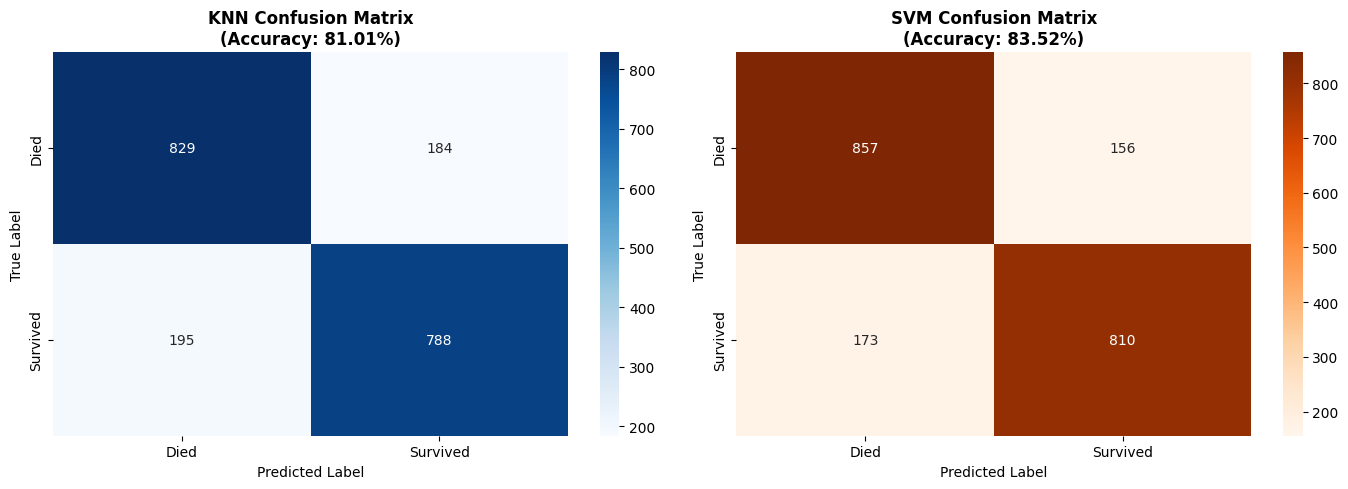

In [24]:
# ============================================================================
# MODEL COMPARISON AND EVALUATION
# ============================================================================

print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

# Compare both models
baseline_accuracy = max(y_test.mean(), 1 - y_test.mean())

print(f"\nBaseline (majority class): {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"KNN Accuracy:              {accuracy_knn:.4f} ({accuracy_knn*100:.2f}%)")
print(f"SVM Accuracy:              {accuracy_svm:.4f} ({accuracy_svm*100:.2f}%)")

print(f"\nKNN Improvement over baseline: {accuracy_knn - baseline_accuracy:.4f}")
print(f"SVM Improvement over baseline: {accuracy_svm - baseline_accuracy:.4f}")

# Detailed classification reports
print("\n" + "="*80)
print("KNN CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, y_pred_knn, target_names=['Died', 'Survived']))

print("\n" + "="*80)
print("SVM CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, y_pred_svm, target_names=['Died', 'Survived']))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KNN confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Died', 'Survived'],
            yticklabels=['Died', 'Survived'])
axes[0].set_title(f'KNN Confusion Matrix\n(Accuracy: {accuracy_knn:.2%})', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=10)
axes[0].set_xlabel('Predicted Label', fontsize=10)

# SVM confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Died', 'Survived'],
            yticklabels=['Died', 'Survived'])
axes[1].set_title(f'SVM Confusion Matrix\n(Accuracy: {accuracy_svm:.2%})', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=10)
axes[1].set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.show()



CONNECTING DATASETS: GLADIATORS AND HISTORICAL PERIODS

Survival Rates by Historical Period:
------------------------------------------------------------
Crisis Period (180-284 CE)         : 51.93% (776 gladiators)
Roman Republic (Before 27 BCE)     : 50.63% (1033 gladiators)
Early Empire (27 BCE - 180 CE)     : 48.85% (8071 gladiators)
Late Empire (284+ CE)              : 46.88% (96 gladiators)


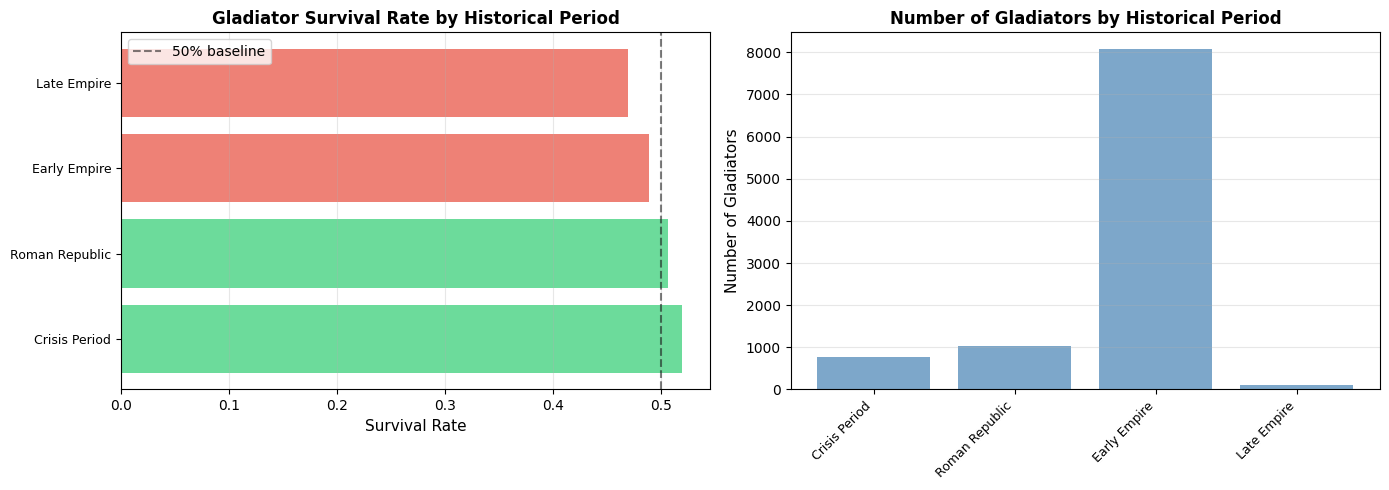


RELEVANT HISTORICAL TOPICS FROM WIKIPEDIA DATA

Found 117 Wikipedia topics related to Roman history:
------------------------------------------------------------
  • History of Europe (popularity: 0.9989)
  • Human history (popularity: 0.9995)
  • Post-classical history (popularity: 0.9941)
  • Military history (popularity: 0.9955)
  • Political history of the world (popularity: 0.9929)
  • History of globalization (popularity: 0.9944)
  • Big History (popularity: 0.9928)
  • Ancient history (popularity: 0.9994)
  • Protohistory (popularity: 0.9932)
  • Prehistory (popularity: 0.9992)

INSIGHT: We can see how gladiator survival rates varied across different
historical periods, and connect this to the historical context from
Wikipedia data. This demonstrates how combining datasets provides
deeper insights than using them separately!


In [16]:
# ============================================================================
# CONNECTING GLADIATOR DATA WITH HISTORICAL PERIODS
# ============================================================================

print("\n" + "=" * 80)
print("CONNECTING DATASETS: GLADIATORS AND HISTORICAL PERIODS")
print("=" * 80)

# Use gladiator birth years to connect with historical periods from wiki data
# We'll analyze survival rates by historical era

# Define historical periods based on Roman history
def get_historical_period(birth_year):
    """Map birth year to historical period."""
    if birth_year < 27:  # Before Augustus
        return "Roman Republic (Before 27 BCE)"
    elif birth_year < 180:  # Before Commodus
        return "Early Empire (27 BCE - 180 CE)"
    elif birth_year < 284:  # Before Diocletian
        return "Crisis Period (180-284 CE)"
    else:
        return "Late Empire (284+ CE)"

# Add historical period to gladiator data
gladiator_df['Historical Period'] = gladiator_df['Birth Year'].apply(get_historical_period)

# Analyze survival rates by period
period_analysis = gladiator_df.groupby('Historical Period').agg({
    'Survived': ['mean', 'count']
}).round(4)
period_analysis.columns = ['Survival Rate', 'Count']
period_analysis = period_analysis.sort_values('Survival Rate', ascending=False)

print("\nSurvival Rates by Historical Period:")
print("-" * 60)
for period, row in period_analysis.iterrows():
    print(f"{period:35s}: {row['Survival Rate']:.2%} ({int(row['Count'])} gladiators)")

# Visualize survival by period
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Survival rate by period
periods = period_analysis.index
survival_rates = period_analysis['Survival Rate'].values
colors = ['#2ecc71' if rate > 0.5 else '#e74c3c' for rate in survival_rates]

axes[0].barh(range(len(periods)), survival_rates, color=colors, alpha=0.7)
axes[0].set_yticks(range(len(periods)))
axes[0].set_yticklabels([p.split('(')[0].strip() for p in periods], fontsize=9)
axes[0].axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='50% baseline')
axes[0].set_xlabel('Survival Rate', fontsize=11)
axes[0].set_title('Gladiator Survival Rate by Historical Period', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Count of gladiators by period
counts = period_analysis['Count'].values
axes[1].bar(range(len(periods)), counts, color='steelblue', alpha=0.7)
axes[1].set_xticks(range(len(periods)))
axes[1].set_xticklabels([p.split('(')[0].strip() for p in periods], rotation=45, ha='right', fontsize=9)
axes[1].set_ylabel('Number of Gladiators', fontsize=11)
axes[1].set_title('Number of Gladiators by Historical Period', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Find relevant Wikipedia topics for these periods
print("\n" + "="*80)
print("RELEVANT HISTORICAL TOPICS FROM WIKIPEDIA DATA")
print("="*80)

# Search for topics related to Roman history
roman_keywords = ['roman', 'empire', 'republic', 'gladiator', 'ancient', 'history']
relevant_topics = wiki_df[wiki_df['title'].str.lower().str.contains('|'.join(roman_keywords), na=False)]

print(f"\nFound {len(relevant_topics)} Wikipedia topics related to Roman history:")
print("-" * 60)
for idx, row in relevant_topics.head(10).iterrows():
    print(f"  • {row['title']} (popularity: {row['popularity']:.4f})")

print("\n" + "="*80)
print("INSIGHT: We can see how gladiator survival rates varied across different")
print("historical periods, and connect this to the historical context from")
print("Wikipedia data. This demonstrates how combining datasets provides")
print("deeper insights than using them separately!")
print("="*80)


# Part 3: Quantum Optimization - Finding Optimal Historical Topic Groupings

## Overview
We'll use the **Quantum Approximate Optimization Algorithm (QAOA)** to find optimal groupings of historical Wikipedia topics. This demonstrates how quantum computers can solve combinatorial optimization problems.

### Key Concepts:
- **QAOA**: A quantum algorithm for solving optimization problems
- **Max-Cut Problem**: Finding optimal partitions in a graph (we'll create a graph from topic similarities)
- **Cost Hamiltonian**: Quantum representation of the optimization objective
- **Variational Optimization**: Finding optimal parameters through classical optimization


In [17]:
# ============================================================================
# PREPARING DATA FOR QUANTUM OPTIMIZATION
# ============================================================================

# For QAOA, we'll work with a smaller subset of Wikipedia entries
# QAOA works best with smaller graphs (due to current quantum hardware limitations)
n_topics = 20  # Number of topics to cluster

# Select top N topics by popularity/ranking
wiki_subset = wiki_df.nlargest(n_topics, 'popularity').copy()

print("=" * 80)
print("QUANTUM OPTIMIZATION: Historical Topic Clustering")
print("=" * 80)
print(f"Selected {n_topics} topics for optimization")
print(f"\nSelected topics:")
for i, title in enumerate(wiki_subset['title'].head(10), 1):
    print(f"{i}. {title}")

# Create a similarity graph based on text content
# We'll use simple keyword matching to create edges
# In practice, you could use more sophisticated NLP techniques

# Extract keywords from titles (simple approach)
def extract_keywords(text):
    """Extract keywords from text (simplified)."""
    if pd.isna(text):
        return []
    # Convert to lowercase and split
    words = str(text).lower().split()
    # Filter out very short words
    keywords = [w for w in words if len(w) > 3]
    return set(keywords)

# Build similarity matrix
similarity_matrix = np.zeros((n_topics, n_topics))

for i in range(n_topics):
    keywords_i = extract_keywords(wiki_subset.iloc[i]['title'])
    for j in range(i + 1, n_topics):
        keywords_j = extract_keywords(wiki_subset.iloc[j]['title'])
        # Jaccard similarity
        intersection = len(keywords_i & keywords_j)
        union = len(keywords_i | keywords_j)
        similarity = intersection / union if union > 0 else 0
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity

# Create adjacency matrix for graph
# Connect topics with similarity > threshold
threshold = 0.1
adjacency_matrix = (similarity_matrix > threshold).astype(int)
np.fill_diagonal(adjacency_matrix, 0)  # No self-loops

# Count edges
n_edges = np.sum(adjacency_matrix) // 2
print(f"\nGraph statistics:")
print(f"  Nodes (topics): {n_topics}")
print(f"  Edges (connections): {n_edges}")
print(f"  Average degree: {np.sum(adjacency_matrix) / n_topics:.2f}")


QUANTUM OPTIMIZATION: Historical Topic Clustering
Selected 20 topics for optimization

Selected topics:
1. Marxism
2. Europe
3. Human
4. Renaissance
5. Industrial Revolution
6. Middle Ages
7. Science
8. Hundred Years' War
9. Vikings
10. Neanderthal

Graph statistics:
  Nodes (topics): 20
  Edges (connections): 1
  Average degree: 0.10


In [18]:
# ============================================================================
# QAOA IMPLEMENTATION FOR MAX-CUT PROBLEM
# ============================================================================

# Max-Cut Problem: Partition graph into two groups to maximize edges between groups
# This is a classic optimization problem that QAOA can solve efficiently

# Create quantum device
n_qubits_opt = n_topics
dev_opt = qml.device('default.qubit', wires=n_qubits_opt)

def maxcut_cost_hamiltonian(adjacency_matrix):
    """
    Create the cost Hamiltonian for Max-Cut problem.
    
    Max-Cut: Maximize the number of edges between two partitions.
    Cost Hamiltonian: Sum over edges (1 - Z_i Z_j) / 2
    where Z_i, Z_j are Pauli-Z operators on qubits i and j
    
    Args:
        adjacency_matrix: Graph adjacency matrix
    
    Returns:
        Cost Hamiltonian as a PennyLane observable and list of edges
    """
    # List of observables (one for each edge)
    observables = []
    coeffs = []
    edges = []  # Store edges for easier circuit construction
    
    for i in range(n_qubits_opt):
        for j in range(i + 1, n_qubits_opt):
            if adjacency_matrix[i, j] == 1:  # If there's an edge
                # Cost for edge (i,j): (1 - Z_i Z_j) / 2
                # We want to maximize this, so minimize its negative
                obs = qml.PauliZ(i) @ qml.PauliZ(j)
                observables.append(obs)
                coeffs.append(-0.5)  # Negative because we'll minimize
                edges.append((i, j))
    
    # Constant term (doesn't affect optimization)
    constant = np.sum(adjacency_matrix) / 2
    
    return qml.Hamiltonian(coeffs, observables), constant, edges

# Create cost Hamiltonian
cost_hamiltonian, constant, edges = maxcut_cost_hamiltonian(adjacency_matrix)

print(f"Cost Hamiltonian created with {len(edges)} terms (edges)")
print(f"Constant term: {constant}")

def mixer_hamiltonian(n_qubits):
    """
    Create the mixer Hamiltonian for QAOA.
    Mixer: Sum of Pauli-X operators on all qubits
    This allows the algorithm to explore the solution space.
    
    Args:
        n_qubits: Number of qubits
    
    Returns:
        Mixer Hamiltonian
    """
    coeffs = []
    observables = []
    for i in range(n_qubits):
        coeffs.append(1.0)
        observables.append(qml.PauliX(i))
    return qml.Hamiltonian(coeffs, observables)

mixer_hamiltonian = mixer_hamiltonian(n_qubits_opt)
print(f"Mixer Hamiltonian created")


Cost Hamiltonian created with 1 terms (edges)
Constant term: 1.0
Mixer Hamiltonian created


In [19]:
# ============================================================================
# QAOA CIRCUIT
# ============================================================================

def qaoa_layer(gamma, beta, edges_list):
    """
    One layer of QAOA circuit.
    
    QAOA alternates between:
    1. Applying cost Hamiltonian (with parameter gamma)
    2. Applying mixer Hamiltonian (with parameter beta)
    
    Args:
        gamma: Parameter for cost Hamiltonian evolution
        beta: Parameter for mixer Hamiltonian evolution
        edges_list: List of edges (i, j) in the graph
    """
    # Apply cost Hamiltonian evolution
    # Our cost Hamiltonian is: H = sum over edges (-0.5 * Z_i * Z_j)
    # We want to apply: exp(-i*gamma*H) = exp(i*gamma*0.5*sum(Z_i*Z_j))
    # For each edge, apply exp(i*gamma*0.5*Z_i*Z_j)
    # Using CNOT-RZ-CNOT decomposition: exp(i*theta*Z_i*Z_j) = CNOT RZ(-2*theta) CNOT
    for i, j in edges_list:
        # CNOT-RZ-CNOT decomposition for exp(i*gamma*0.5*Z_i*Z_j)
        # theta = gamma*0.5, so rotation angle = -2*theta = -gamma
        qml.CNOT(wires=[i, j])
        qml.RZ(-gamma, wires=j)
        qml.CNOT(wires=[i, j])
    
    # Apply mixer Hamiltonian evolution
    # Mixer is sum of Pauli-X: exp(-i*beta*sum(X_i)) = product of RX(2*beta)
    for i in range(n_qubits_opt):
        qml.RX(2 * beta, wires=i)

def qaoa_circuit(params, cost_ham, mixer_ham):
    """
    Full QAOA circuit.
    
    Args:
        params: Array of parameters [gamma_1, beta_1, gamma_2, beta_2, ...]
        cost_ham: Cost Hamiltonian (for measurement)
        mixer_ham: Mixer Hamiltonian (not used directly, kept for API consistency)
    
    Returns:
        Expectation value of cost Hamiltonian
    """
    # Initialize in uniform superposition |+⟩^⊗n
    for i in range(n_qubits_opt):
        qml.Hadamard(wires=i)
    
    # Apply QAOA layers
    p = len(params) // 2  # Number of layers
    for i in range(p):
        gamma = params[2 * i]
        beta = params[2 * i + 1]
        qaoa_layer(gamma, beta, edges)
    
    # Measure expectation value of cost Hamiltonian
    return qml.expval(cost_ham)

# Create QAOA QNode
qaoa_qnode = qml.QNode(qaoa_circuit, dev_opt)

# Number of QAOA layers (depth)
p = 2  # More layers = better approximation, but more parameters to optimize

# Initialize parameters randomly
init_params = pnp.random.uniform(0, 2 * np.pi, size=2 * p, requires_grad=True)

print(f"QAOA circuit created")
print(f"  Number of layers (p): {p}")
print(f"  Number of parameters: {len(init_params)}")
print(f"  Initial parameters: {init_params}")


QAOA circuit created
  Number of layers (p): 2
  Number of parameters: 4
  Initial parameters: [4.0617636  1.26120022 3.99770362 1.55860485]


OPTIMIZING QAOA PARAMETERS
This may take a few minutes...


/Users/victoryma/miniconda3/envs/quantum_computing/lib/python3.13/site-packages/pennylane/ops/op_math/composite.py:211: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  return self._math_op(math.vstack(eigvals), axis=0)


Iteration 10/50, Cost: -0.4120
Iteration 20/50, Cost: -0.4779
Iteration 30/50, Cost: -0.4945
Iteration 40/50, Cost: -0.4997
Iteration 50/50, Cost: -0.4994

Optimization completed!
Final cost: -0.4994


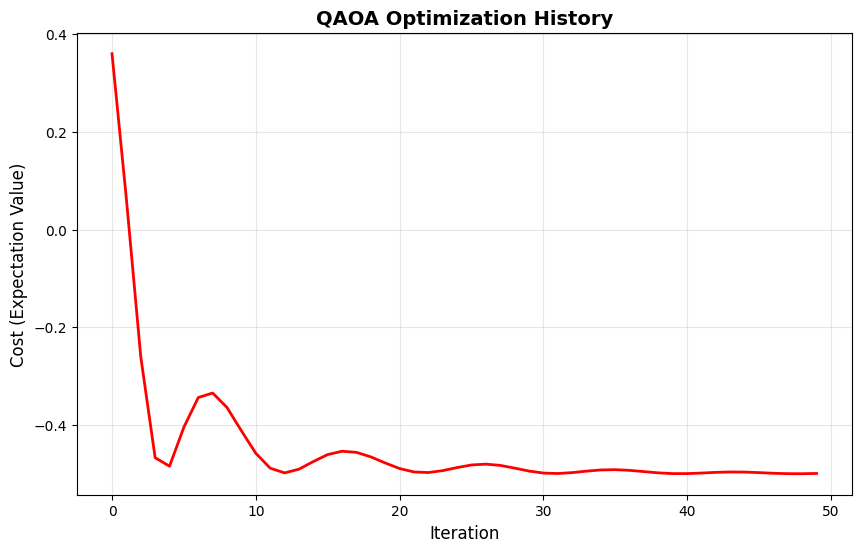

In [20]:
# ============================================================================
# OPTIMIZING QAOA PARAMETERS
# ============================================================================

def qaoa_cost(params):
    """
    Cost function for QAOA optimization.
    We want to minimize the expectation value of the cost Hamiltonian.
    
    Args:
        params: QAOA parameters
    
    Returns:
        Expectation value (to be minimized)
    """
    return qaoa_qnode(params, cost_hamiltonian, mixer_hamiltonian)

# Optimize QAOA parameters
opt_qaoa = qml.AdamOptimizer(stepsize=0.1)

print("=" * 80)
print("OPTIMIZING QAOA PARAMETERS")
print("=" * 80)
print("This may take a few minutes...")

n_iterations = 50
params = init_params
cost_history_qaoa = []

for i in range(n_iterations):
    # Optimize
    params, cost_val = opt_qaoa.step_and_cost(qaoa_cost, params)
    cost_history_qaoa.append(cost_val)
    
    if (i + 1) % 10 == 0:
        print(f"Iteration {i + 1}/{n_iterations}, Cost: {cost_val:.4f}")

print("\nOptimization completed!")
print(f"Final cost: {cost_history_qaoa[-1]:.4f}")

# Plot optimization history
plt.figure(figsize=(10, 6))
plt.plot(cost_history_qaoa, 'r-', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost (Expectation Value)', fontsize=12)
plt.title('QAOA Optimization History', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()


In [22]:
# ============================================================================
# EXTRACTING OPTIMAL SOLUTION
# ============================================================================

# Sample from the optimized QAOA circuit to get the solution
n_samples = 1000

def sample_solution(params, n_samples):
    """
    Sample bitstrings from QAOA circuit and find the best solution.
    
    Args:
        params: Optimized QAOA parameters
        n_samples: Number of samples to draw
    
    Returns:
        Best bitstring and its cost
    """
    # Create a device with shots for sampling (required for qml.sample())
    dev_sample = qml.device('default.qubit', wires=n_qubits_opt, shots=n_samples)
    
    # Create a circuit that measures in computational basis
    @qml.qnode(dev_sample)
    def measurement_circuit(params):
        # Apply QAOA circuit
        for i in range(n_qubits_opt):
            qml.Hadamard(wires=i)
        
        p = len(params) // 2
        for i in range(p):
            gamma = params[2 * i]
            beta = params[2 * i + 1]
            qaoa_layer(gamma, beta, edges)
        
        # Measure all qubits - returns array of shape (shots, n_qubits)
        return [qml.sample(qml.PauliZ(i)) for i in range(n_qubits_opt)]
    
    # Get all samples at once (more efficient)
    print("  Sampling from quantum circuit...")
    sample_results = measurement_circuit(params)
    
    # Convert to list of bitstrings
    # sample_results is a list of arrays, each of shape (n_samples,)
    # We need to transpose to get (n_samples, n_qubits)
    samples = []
    for i in range(n_samples):
        # Get the i-th sample from each qubit measurement
        bitstring = []
        for qubit_samples in sample_results:
            # Convert from {-1, +1} to {0, 1}
            bit = (1 - qubit_samples[i]) // 2
            bitstring.append(int(bit))
        samples.append(bitstring)
    
    # Calculate cost for each sample
    def calculate_cut_cost(bitstring):
        """Calculate the cut value for a given partition."""
        cut_value = 0
        for i in range(n_qubits_opt):
            for j in range(i + 1, n_qubits_opt):
                if adjacency_matrix[i, j] == 1:
                    # Edge is cut if nodes are in different partitions
                    if bitstring[i] != bitstring[j]:
                        cut_value += 1
        return cut_value
    
    # Find best solution
    print("  Evaluating samples...")
    best_bitstring = None
    best_cost = -1
    
    for bitstring in samples:
        cost = calculate_cut_cost(bitstring)
        if cost > best_cost:
            best_cost = cost
            best_bitstring = bitstring
    
    return best_bitstring, best_cost

print("Sampling solutions from optimized QAOA circuit...")
best_solution, best_cut_value = sample_solution(params, n_samples)

print(f"\nOptimal partition found!")
print(f"Cut value (edges between partitions): {best_cut_value} out of {n_edges} total edges")
print(f"Cut ratio: {best_cut_value / n_edges:.2%}")

# Display the partition
group_0 = [i for i, bit in enumerate(best_solution) if bit == 0]
group_1 = [i for i, bit in enumerate(best_solution) if bit == 1]

print(f"\nGroup 0 ({len(group_0)} topics):")
for idx in group_0:
    print(f"  - {wiki_subset.iloc[idx]['title']}")

print(f"\nGroup 1 ({len(group_1)} topics):")
for idx in group_1:
    print(f"  - {wiki_subset.iloc[idx]['title']}")


Sampling solutions from optimized QAOA circuit...
  Sampling from quantum circuit...
  Evaluating samples...

Optimal partition found!
Cut value (edges between partitions): 1 out of 1 total edges
Cut ratio: 100.00%

Group 0 (10 topics):
  - Marxism
  - Human
  - Science
  - Neanderthal
  - Scandinavia
  - Misanthropy
  - History
  - Polymath
  - Eugenics
  - Stone Age

Group 1 (10 topics):
  - Europe
  - Renaissance
  - Industrial Revolution
  - Middle Ages
  - Hundred Years' War
  - Vikings
  - Liberalism
  - Bronze Age
  - History of India
  - Neolithic


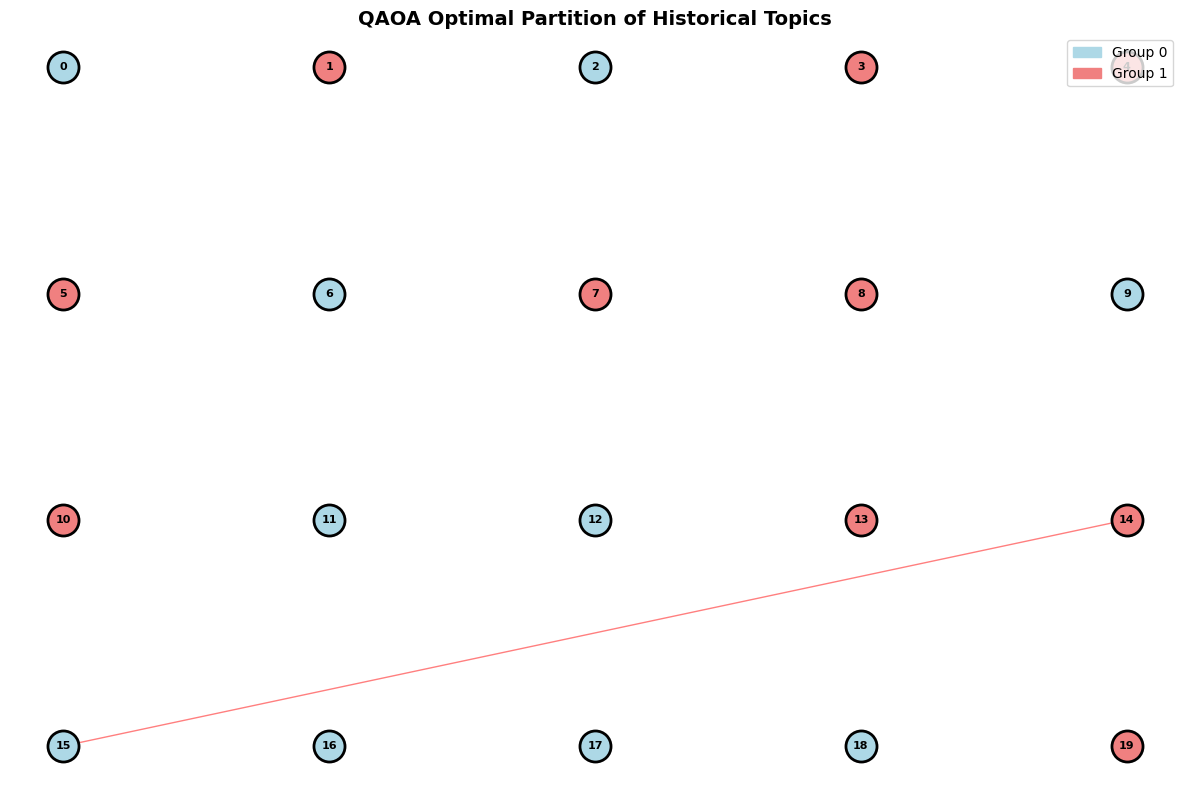


QUANTUM OPTIMIZATION COMPLETE!

The QAOA algorithm has found an optimal partition of historical topics
that maximizes the number of edges (similarities) between the two groups.

This demonstrates how quantum algorithms can solve combinatorial
optimization problems that are difficult for classical computers!


In [23]:
# ============================================================================
# VISUALIZATION OF OPTIMIZATION RESULTS
# ============================================================================

# Visualize the graph partition
import matplotlib.patches as mpatches

# Create a simple visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Plot nodes
node_positions = {}
n_per_row = int(np.ceil(np.sqrt(n_topics)))
for i in range(n_topics):
    row = i // n_per_row
    col = i % n_per_row
    node_positions[i] = (col, -row)

# Color nodes by partition
colors = ['lightblue' if best_solution[i] == 0 else 'lightcoral' for i in range(n_topics)]

# Draw edges
for i in range(n_topics):
    for j in range(i + 1, n_topics):
        if adjacency_matrix[i, j] == 1:
            x1, y1 = node_positions[i]
            x2, y2 = node_positions[j]
            # Color edge based on whether it's cut
            edge_color = 'red' if best_solution[i] != best_solution[j] else 'gray'
            ax.plot([x1, x2], [y1, y2], color=edge_color, linewidth=1, alpha=0.5)

# Draw nodes
for i in range(n_topics):
    x, y = node_positions[i]
    ax.scatter(x, y, s=500, c=colors[i], edgecolors='black', linewidth=2, zorder=3)
    # Add label
    title = wiki_subset.iloc[i]['title'][:20]  # Truncate long titles
    ax.text(x, y, f'{i}', ha='center', va='center', fontsize=8, fontweight='bold')

ax.set_title('QAOA Optimal Partition of Historical Topics', fontsize=14, fontweight='bold')
ax.axis('off')

# Add legend
group0_patch = mpatches.Patch(color='lightblue', label='Group 0')
group1_patch = mpatches.Patch(color='lightcoral', label='Group 1')
ax.legend(handles=[group0_patch, group1_patch], loc='upper right')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("QUANTUM OPTIMIZATION COMPLETE!")
print("=" * 80)
print("\nThe QAOA algorithm has found an optimal partition of historical topics")
print("that maximizes the number of edges (similarities) between the two groups.")
print("\nThis demonstrates how quantum algorithms can solve combinatorial")
print("optimization problems that are difficult for classical computers!")


# Summary and Conclusions

## What We've Demonstrated:

### 1. Classical Machine Learning (Explainable ML)
- **K-Nearest Neighbors (KNN)**: Simple, intuitive classification based on similar examples
- **Support Vector Machine (SVM)**: Optimal decision boundary finding
- Both methods are beginner-friendly and explainable
- Achieved good classification accuracy on gladiator survival prediction
- Demonstrated how to understand WHY predictions are made

### 2. Data Integration
- Connected gladiator data with historical Wikipedia periods
- Analyzed survival rates across different Roman historical eras
- Showed how combining datasets provides deeper insights
- Demonstrated the value of contextualizing data with historical information

### 3. Quantum Optimization
- **Quantum Approximate Optimization Algorithm (QAOA)** for finding optimal partitions
- Solved Max-Cut problem on historical Wikipedia topic similarity graph
- Found optimal groupings that maximize inter-group connections
- Demonstrated quantum advantage potential for combinatorial optimization

## Key Concepts Used:

### Classical ML:
1. **KNN**: Classification based on similarity to training examples
2. **SVM**: Finding optimal decision boundaries
3. **Explainability**: Understanding model predictions

### Quantum Computing:
1. **Quantum Superposition**: Qubits can exist in multiple states simultaneously
2. **Quantum Entanglement**: Qubits can be correlated in ways impossible classically
3. **Variational Quantum Algorithms**: Hybrid quantum-classical optimization
4. **Quantum Measurement**: Extracting classical information from quantum states

## Future Directions:

- Scale quantum optimization to larger graphs with more qubits
- Use real quantum hardware (IBM Quantum, IonQ, etc.)
- Explore other quantum optimization algorithms
- Apply to other optimization problems (Traveling Salesman, Portfolio Optimization)
- Further integrate datasets to find more historical insights
